In [126]:
import gym
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
import wandb

In [127]:
input_shape = 2  # == env.observation_space.shape
n_outputs = 3
class Model(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_shape, 32),
            nn.ELU(),
            nn.Linear(32, 32),
            nn.ELU(),
            nn.Linear(32, n_outputs)
        )

    def forward(self, x):
        if isinstance(x, np.ndarray):
            x = torch.tensor(x)
        return self.model(x)

model = Model()
target_model = Model()

In [128]:
model=Model()

In [129]:
model=torch.load('best_model_weights.pth')

In [135]:
target_model=torch.load('target_model_weights.pth')

In [136]:
xs=np.linspace(-1.2,0.6,100)
vs=np.linspace(-0.07,0.07,100)

In [137]:
X, V = np.meshgrid(xs, vs)

In [138]:
phase_space_points=torch.stack([torch.Tensor(X.flatten()),torch.Tensor(V.flatten())],1)

In [139]:
with torch.no_grad():
    #z0=target_model(phase_space_points)
    z=model(phase_space_points)

In [140]:
#z0=z0.reshape(100,100,3)
z=z.reshape(100,100,3)

#Z0=z0.max(dim=2)[0].numpy()
Z=z.max(dim=2)[0].numpy()


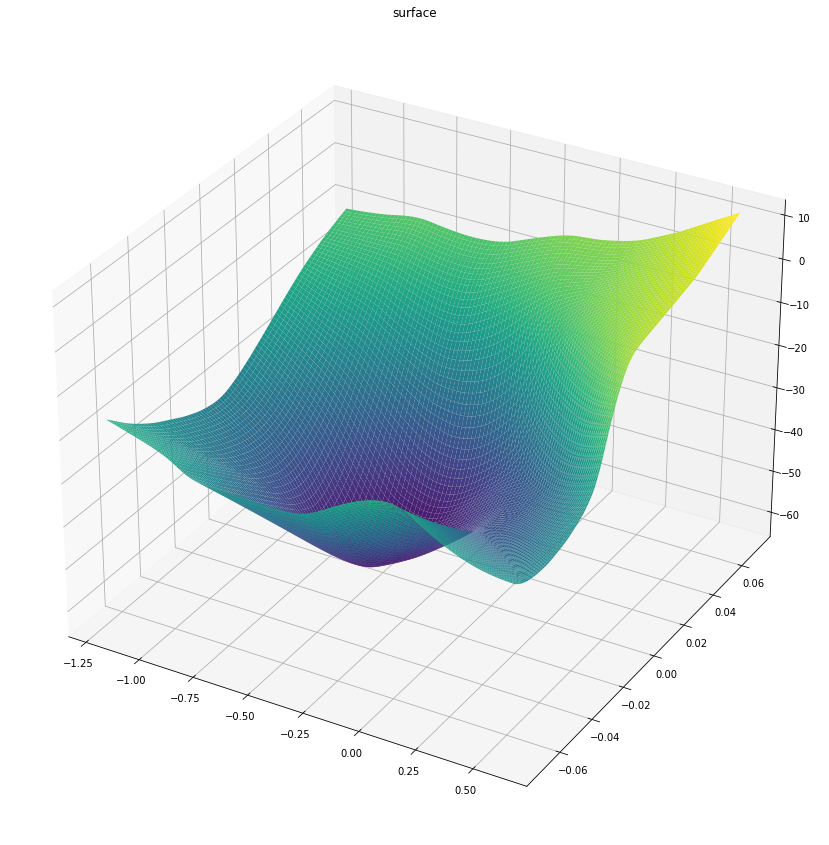

In [141]:
fig = plt.figure(figsize=(15,15))

ax = plt.axes(projection='3d')
#ax.plot_surface(X, V, Z0, rstride=1, cstride=1,
#                cmap='viridis', edgecolor='none',alpha=.3)
ax.plot_surface(X, V, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('surface');



In [142]:
env = gym.make("MountainCar-v0")


def epsilon_greedy_policy(state, epsilon=0):
    """
    Takes a random action with probability epsilon and a greedy one with probability 1-epsilon
    """
    if torch.rand(1) < epsilon:
        return torch.randint(2, (1,))[0]
    else:
        with torch.no_grad():
            Q_values = model(state[np.newaxis])
        return torch.argmax(Q_values[0])
    
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon).numpy()
    next_state, reward, done, info = env.step(action)
    #replay_buffer.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

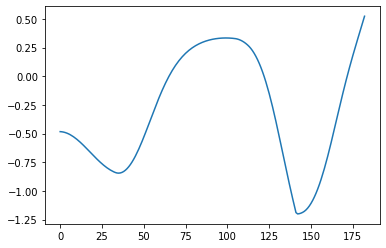

In [153]:
observations=[]
obs = env.reset()
done=False
observations.append(obs)
while not done:
    epsilon = 0
    obs, reward, done, info = play_one_step(env, obs, epsilon)
    observations.append(obs)
observations=np.stack(observations)
plt.plot(observations[:,0])


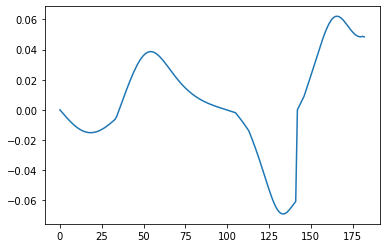

In [154]:
plt.plot(observations[:,1])


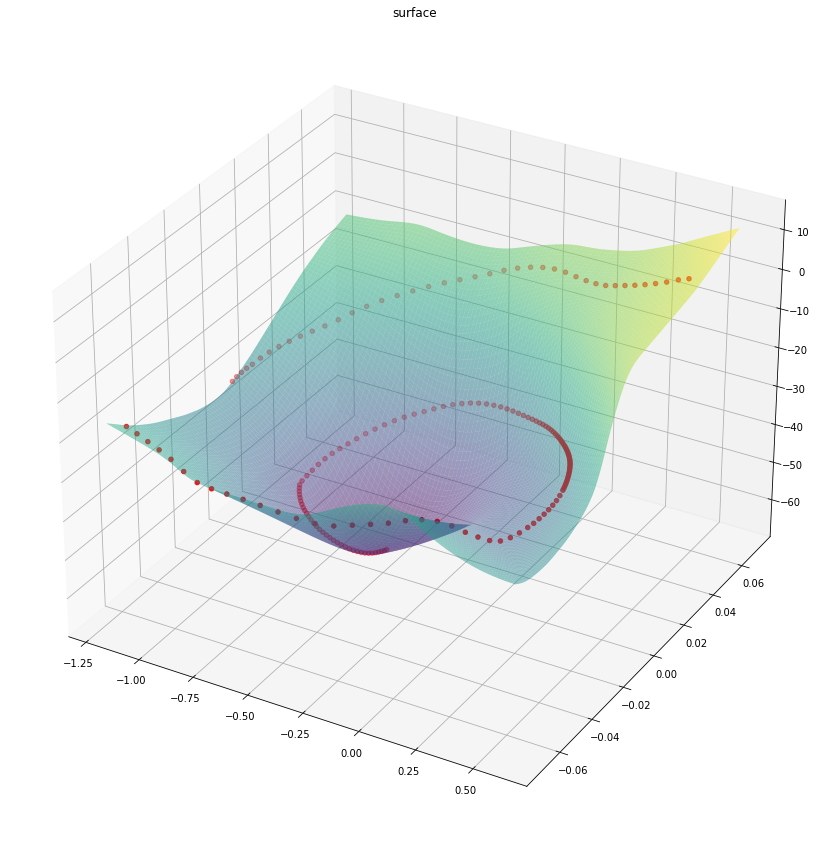

In [155]:
with torch.no_grad():
    z_=model(observations)
    
data=np.concatenate([observations,z_.max(1)[0].numpy()[:,np.newaxis]],1)
fig = plt.figure(figsize=(15,15))

ax = plt.axes(projection='3d')
ax.plot_surface(X, V, Z1, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none',alpha=.5)
ax.scatter(data[:,0],data[:,1],data[:,2],color='r')
ax.set_title('surface');

